# Functional Data Analysis: Curve Registration

Feature (landmark) registration of a synthetic dataset of double logistic functions.

Based on __Ramsay, J. and Silverman, B. W. (2005). The registration and display of functional data. In *Functional Data Analysis* (2nd ed., pp. 127-145).__

---

We'll be working with some basic libraries: NumPy and SciPy.

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

For simplicity, our functions' domain will be $\left[0,1\right]$:

In [2]:
x = np.linspace([0],[1],101)
dx = np.diff(x,axis=0).mean()

We'll work with the [logistic function](https://en.wikipedia.org/wiki/Logistic_function), which has the form $f(x) = \frac{L}{1+exp({-k(x-x_0)})}$. This function sees many applications in areas ranging from biology to economics. We can use it to model the [growth of a population](https://en.wikipedia.org/wiki/Population_growth#Logistic_equation), for example.

In [3]:
def logistic(x, x0=0, L=1, k=1):
    return L/(1+np.exp(-k*(x-x0)))

We define it in terms of its maximum value and the slope and $x$ value at its inflection point.

In [4]:
max_value = np.random.uniform(0.5, 1)
max_slope = np.random.uniform(2, 8)
dt = np.random.uniform(0.25, 0.75)
y = logistic(x,dt,max_value,4*max_slope/max_value)

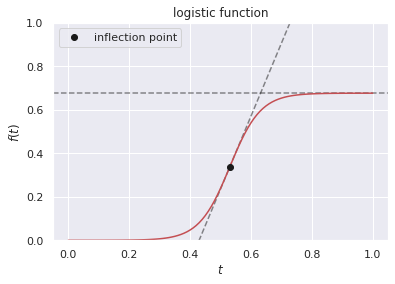

In [5]:
fig,ax = plt.subplots()
ax.axhline(max_value,c='k',ls='--',alpha=0.5)
ax.plot(x,max_slope*x+max_value/2-max_slope*dt,'--k',alpha=0.5)
ax.plot(x,y,'r');
ax.plot(dt,max_value/2,'ok',label='inflection point')
ax.set_ylim([0,1])
ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$f(t)$');
ax.set_title('logistic function');
ax.legend();

To make things a little more interesting, we define the double logistic function as $g(x) = f(x ; L_1,k_1,x_{01}) - f(x ; L_2,k_2,x_{02})$, the difference between two logistic functions. This creates a pattern of growth and decay.

In [6]:
def double_logistic(x, x0=[0,1], L=1, k=[1,1]):
    return logistic(x,x0[0],L,k[0])-logistic(x,x0[1],L,k[1])

In [7]:
max_slope = np.random.uniform(2, 8, 2)
dt = np.random.uniform([0.1, 0.6], [0.4, 0.9])
max_value = np.random.uniform(0.5, 1)
y = double_logistic(x,dt,max_value,4*max_slope/max_value)

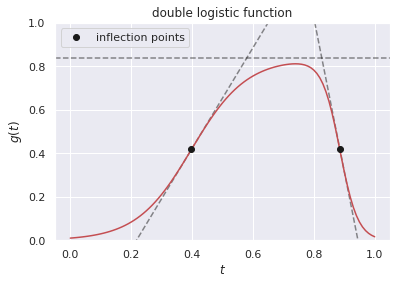

In [8]:
fig,ax = plt.subplots()
ax.axhline(max_value,c='k',ls='--',alpha=0.5)
ax.plot(x,max_slope[0]*x+max_value/2-max_slope[0]*dt[0],'--k',alpha=0.5)
ax.plot(x,-max_slope[1]*x+max_value/2+max_slope[1]*dt[1],'--k',alpha=0.5)
ax.plot(x,y,'r');
ax.plot(dt,[max_value/2]*2,'ok',label='inflection points')
ax.set_ylim([0,1])
ax.set_title('double logistic function');
ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$g(t)$');
ax.legend();

We are now done with the definitions and can generate our very own dataset of randomly parameterized double logistic functions.

---

In [9]:
N = 5
max_slope = np.random.uniform(4, 8, [2,N])
dt = np.random.uniform([[0.1], [0.5]], [[0.5], [0.9]], [2,N])
max_value = np.random.uniform(0.5, 1, [1,N])

In [10]:
data = double_logistic(x,dt,max_value,4*max_slope/max_value)

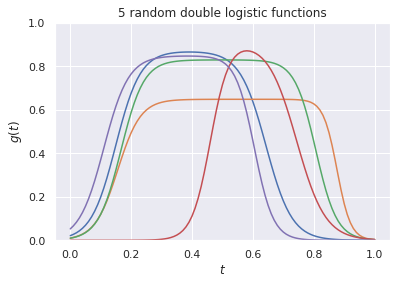

In [11]:
fig,ax = plt.subplots();
ax.plot(x,data);
ax.set_ylim([0,1])
ax.set_title(f'{N} random double logistic functions');
ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$g(t)$');


Notice how each function differs from the others both in amplitude (how high it goes) and phase (at which point in time does it grow or decay).

Some start growing sooner, others later. Some grow faster, others slower. The same goes for the decay.

Now suppose we are interested in assessing the average behaviour of the functions in our dataset. The first idea that comes to mind is taking the average of the functions' values at each point $t$.

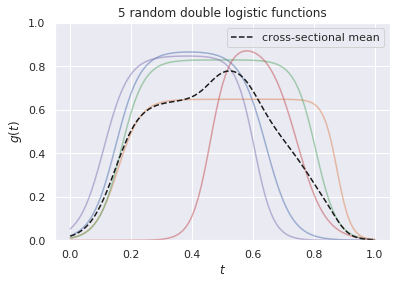

In [12]:
fig,ax = plt.subplots();
ax.plot(x,data,alpha=0.5);
ax.plot(x,data.mean(axis=1),'--k',label='cross-sectional mean');
ax.set_ylim([0,1])
ax.set_title(f'{N} random double logistic functions');
ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$g(t)$');
ax.legend();

Clearly simply taking the mean at each point in time (what we call cross-sectional mean) does not do the functions justice.

The resulting average function is not really representative of any of the functions in our dataset. It does not look like a double logistic function at all.

That's because our functions are not necessarily aligned in time, so it makes no sense to compare them at the same points.

To fix our cross-sectional mean, we'll try to align them before taking the average at each point $t$.

To align the functions in time, we need to transform time itself for each of the functions.

This alignment is called *curve registration*.

> *The need to transform curves by transforming their arguments, which
we call curve registration, can be motivated as follows. The rigid metric of
physical time may not be directly relevant to the internal dynamics of many
real-life systems. Rather, there can be a sort of biological or meteorological
time scale that can be nonlinearly related to physical time, and can vary
from case to case.*
>
> *Human growth, for example, is the consequence of a complex sequence of
hormonal events that do not happen at the same rate for every child. The
intensity of the pubertal growth spurts of two children should be compared
at their respective ages of peak velocity rather than at any fixed age. A
colleague with a musical turn of mind refers to this as differences in the
[tempo](https://www.youtube.com/watch?v=xDAsABdkWSc) of growth.*
>
> *Similarly, weather is driven by ocean currents, reflectance changes for
land surfaces, and other factors that are timed differently for different spatial locations and different years. Winter comes early in some years, and
late in others, and typically arrives later at some weather stations than
others. We need to assess how cold the average winter is at the time the
average temperature bottoms out rather than at any fixed time.*
>
> Ramsay, J. and Silverman, B. W. (2005) *Functional Data Analysis* p. 128-129

This means that each person, plant, weather season etc. has their own internal time and in order to compare different people or plants or the weather in different years and places we must first align the times of the individuals.

We'll be looking for the transformations $h_i$ of time such that the registered curves $x^*_i(t) = x_i[h_i(t)]$ are all aligned.

This can be done by first aligning the *landmarks* of each curve. A landmark of a curve is a feature to which we can associate an instant of time *t*. All landmarks must appear in the same order for each of the time series.

If we warp the functions in such a way that their landmarks are aligned, taking the cross-sectional mean won't cause those distortions in the resulting curve.

In the case of our double logistic functions, we'll choose the landmarks as their inflection points: the extrema (maximum and minimum) of the derivative.

For the maximum of each derivative:

In [13]:
dmax = np.diff(data,n=1,axis=0).argmax(axis=0)*dx
dmax

array([0.14, 0.15, 0.16, 0.45, 0.11])

Notice how the points we calculated correspond well to those we used to define our functions:

In [14]:
dt[0]

array([0.14919743, 0.15599499, 0.16663303, 0.460226  , 0.1102703 ])

In [15]:
np.linalg.norm(dmax-dt[0])/N

0.0032813027831034443

For the minimum of each derivative:

In [16]:
dmin = np.diff(data,n=1,axis=0).argmin(axis=0)*dx
dmin

array([0.64, 0.87, 0.8 , 0.74, 0.6 ])

Notice again how the points we calculated correspond well to those we used to define our functions:

In [17]:
dt[1]

array([0.6429034 , 0.87636877, 0.80661723, 0.74351978, 0.60475365])

In [18]:
np.linalg.norm(dmin-dt[1])/N

0.002260661816797921

We set our landmarks as these calculated points.

In [19]:
landmarks = np.concatenate([[dmax],[dmin]])
landmarks

array([[0.14, 0.15, 0.16, 0.45, 0.11],
       [0.64, 0.87, 0.8 , 0.74, 0.6 ]])

We want to align these landmarks to the same instants in time. Since we are interested in knowing the average behaviour of our curves, one reasonable choice would be to align them to their average.

In [20]:
landmarks_mean = landmarks.mean(axis=1)
landmarks_mean

array([0.202, 0.73 ])

We can now construct our transformations $h_i$ that will align the curves. 

Let's note the $f$-th landmark of the $i$-th curve as $t_{i,f}$, and the average of $t_{i,f}$ over all curves as $t_{0,f}$.

We want $h_i$ such that $h_i(t_{0,f}) = t_{i,f}$, so that $x_i^*(t_{0,f}) = x_i[h_i(t_{0,f})] = x_i(t_{i,f})$ for all $x_i$, i.e. each landmark will happen at the same time $t_{0,f}$ for all curves.

Plotted on a grid, it looks like this:

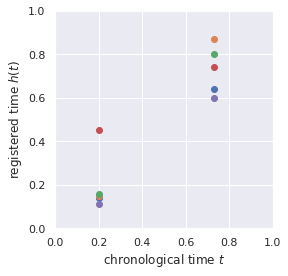

In [21]:
fig,ax = plt.subplots()
ax.plot(landmarks_mean,landmarks,'o')
ax.set_xlabel(r'chronological time $t$'); 
ax.set_ylabel(r'registered time $h(t)$');
ax.set_xlim([0,1]); ax.set_ylim([0,1]); 
ax.set_aspect('equal', 'box');

To find the full transformations $h_i$, all we need is to interpolate these points.

We must also remeber to respect some properties:
- $h_i(0) = 0$, the initial time is fixed;
- $h_i(1) = 1$, the final time is fixed;
- $h_i(t)$ is strictly monotonically increasing (time does not stop nor does it run backwards - [or does it?](https://en.wikipedia.org/wiki/Arrow_of_time))

We apply the PCHIP monotonic cubic interpolation so as to respect this last property.

In [22]:
t = np.concatenate([[0],landmarks_mean,[1]])
ht = np.concatenate([np.zeros([1,N]), landmarks, np.ones([1,N])])

warpings = PchipInterpolator(t,ht,axis=0)(x).squeeze()

Our full transformations (or *warpings*) look like this:

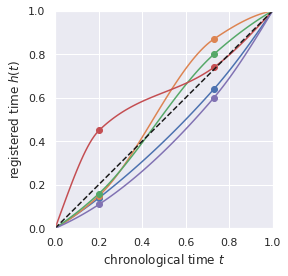

In [23]:
fig,ax = plt.subplots()
ax.plot(x,warpings)
ax.set_prop_cycle(None)
ax.plot(landmarks_mean,landmarks,'o');
ax.plot(x,x,'--k')
ax.set_xlabel(r'chronological time $t$'); 
ax.set_ylabel(r'registered time $h(t)$');
ax.set_xlim([0,1]); ax.set_ylim([0,1]); 
ax.set_aspect('equal', 'box');

Notice how a warping curve being higher than the others means that the original curve was late with respect to the rest at that given instant, and thus the warping is trying to "speed" the curve up.

Finally, we transform the curves with these warpings, using a cubic spline interpolator to find the new values of $x_i$ for the warped time instants.

In [24]:
registered_data = np.array([CubicSpline(x.squeeze(),data[:,i],axis=0)(warpings[:,i]).squeeze() for i in range(N)]).T

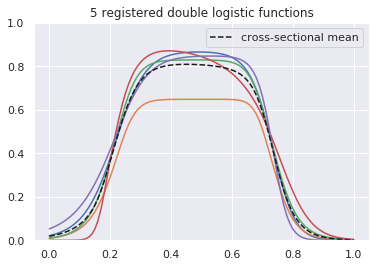

In [25]:
fig,ax = plt.subplots();
ax.plot(x,registered_data);
ax.plot(x,registered_data.mean(axis=1),'--k',label='cross-sectional mean');
ax.set_ylim([0,1])
ax.set_title(f'{N} registered double logistic functions');
ax.legend();

The mean curve taken from the registered curves describes the dataset much better, taking into account both amplitude and timing of the original functions.

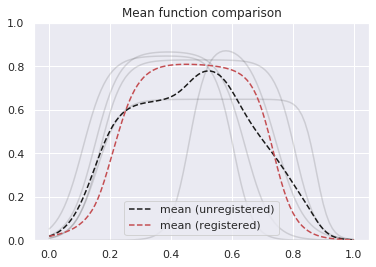

In [26]:
fig,ax = plt.subplots();
ax.plot(x,data,'k',alpha=.1/np.log10(N));
ax.plot(x,data.mean(axis=1),'--k',label='mean (unregistered)');
ax.plot(x,registered_data.mean(axis=1),'--r',label='mean (registered)');
ax.set_ylim([0,1])
ax.set_title(f'Mean function comparison');
ax.legend();

This technique may be applied whenever we need to get a sense of the average behaviour of a set of similar time series.

Notice how the landmark points may be inferred directly from the data, with the possibility of exploring features other than inflection points.